<a href="https://colab.research.google.com/github/MrCoeg/Skripsi/blob/main/1%20Key%20Thumb_Optimized%20FPS%20performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Menghubungkan ke Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import gdown
file_id = "1f1YDfcYRZo2XzkJAsIg1YZHUHd0THABB"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1f1YDfcYRZo2XzkJAsIg1YZHUHd0THABB
To: /content/Dataset.zip
100%|██████████| 390M/390M [00:04<00:00, 85.6MB/s]


'Dataset.zip'

In [3]:
!unzip 'Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/rgb/00037591.jpg  
  inflating: Dataset/rgb/00037538.jpg  
  inflating: Dataset/rgb/00037543.jpg  
  inflating: Dataset/rgb/00037547.jpg  
  inflating: Dataset/rgb/00037553.jpg  
  inflating: Dataset/rgb/00037563.jpg  
  inflating: Dataset/rgb/00037549.jpg  
  inflating: Dataset/rgb/00037545.jpg  
  inflating: Dataset/rgb/00037558.jpg  
  inflating: Dataset/rgb/00037562.jpg  
  inflating: Dataset/rgb/00037511.jpg  
  inflating: Dataset/rgb/00037519.jpg  
  inflating: Dataset/rgb/00037542.jpg  
  inflating: Dataset/rgb/00037554.jpg  
  inflating: Dataset/rgb/00037552.jpg  
  inflating: Dataset/rgb/00037615.jpg  
  inflating: Dataset/rgb/00037548.jpg  
  inflating: Dataset/rgb/00037561.jpg  
  inflating: Dataset/rgb/00037555.jpg  
  inflating: Dataset/rgb/00037539.jpg  
  inflating: Dataset/rgb/00037512.jpg  
  inflating: Dataset/rgb/00037520.jpg  
  inflating: Dataset/rgb/00037541.jpg  
  inflating: Dataset/rgb/0003

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from tqdm import tqdm

# Variabel Parameter Kontrol Program

# Index dari N-Keypoint yang dipilih
INDEX_KEYPOINTS = [4]
N_KEYPOINTS = 1

# Channel warna pada input image
N_IMG_CHANNELS = 3
# Size Image setelah tahap preprocesing resize
MODEL_IMG_SIZE = 128

RAW_IMG_SIZE = 224

# Property dari mean dan stds dataset untuk normalisasi
# Nilai didapat menggunakan get_norm_params
DATASET_MEANS = [0.4837, 0.4650, 0.4397]
DATASET_STDS = [0.2331, 0.2338, 0.2659]

# Neuron model CNN
MODEL_NEURONS = 16

# Blur Size
fg_size = 51
fgk_size = 3

# colormap untuk matplotlib
COLORMAP = {
    "thumb": {"ids": [0], "color": "g"},
    "index": {"ids": [], "color": "c"},
    "middle": {"ids": [], "color": "b"},
    "ring": {"ids": [], "color": "m"},
    "little": {"ids": [], "color": "r"},
}

# Mengubah 3D keypoint dari Freihand Dataset menjadi 2D Keypoint
# Operasi memanfaatkan Camera Intrinsik
# Kode disediakan dari Dataset
def projectPoints(xyz, K):
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    uv = uv[:, :2] / uv[:, -1:]
    return uv[INDEX_KEYPOINTS]

# Kode ini untuk mencari mean dan std dari dataset
def get_norm_params(dataloader):
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    # perulangan untuk iterate dataloader pytorch dengan return index dan batch data
    for i, sample in tqdm(enumerate(dataloader)):

        # mengambil raw image dari iterasi batch pertama
        data = sample["image_raw"]

        # berapa banyak image dalam satu batch
        batch_samples = data.size(0)

        # re-shape data menjadi [batch, channel, num_pixel]
        data = data.view(batch_samples, data.size(1), -1)

        # mendapatkan mean dan std menggunakan fungsi mean dan sum
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return {"mean": mean, "std": std}

# kode ini untuk mengubah keypoint menjadi heatmap
def vector_to_heatmaps(keypoints):
    # membuat heatmap kosong
    heatmaps = np.zeros([N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE])

    # iterate keypoint yang ada
    for k, (x, y) in enumerate(keypoints):

        # mengubah keypoint koordinate menjadi heatmap
        # kordinate x,y akan dijadikan 1 pada heatmap untuk proses blur
        x, y = int(x * MODEL_IMG_SIZE), int(y * MODEL_IMG_SIZE)
        if (0 <= x < MODEL_IMG_SIZE) and (0 <= y < MODEL_IMG_SIZE):
            heatmaps[k, int(y), int(x)] = 1

    # blur heatmap agar model menjadi robust
    heatmaps = blur_heatmaps(heatmaps)
    return heatmaps

# blur image menggunakan gaussianblur
def blur_heatmaps(heatmaps):
    heatmaps_blurred = heatmaps.copy()
    # nilai heatmap satu yang merupakan koordinat keypoint
    # dilakukan pengebluran menggunakan gaussian blur
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (fg_size, fg_size), fgk_size)
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()
    return heatmaps_blurred

# Loss function IoU
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()
        self.EPSILON = 1e-6

    def _op_sum(self, x):
        return x.sum(-1).sum(-1)

    # Rumus untuk mendapatkan IoU
    def forward(self, y_pred, y_true):
        inter = self._op_sum(y_true * y_pred)
        union = (
            self._op_sum(y_true ** 2)
            + self._op_sum(y_pred ** 2)
            - self._op_sum(y_true * y_pred)
        )
        iou = (inter + self.EPSILON) / (union + self.EPSILON)
        iou = torch.mean(iou)
        return 1 - iou


# mengubah heatmap kembali menjadi kordinat
def heatmaps_to_coordinates(heatmaps):

    # mendapatkan banyak image dalam batch
    batch_size = heatmaps.shape[0]

    # mendapatkan nilai total dari heatmap width dan height
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])

    # normalisasi heatmap dengan membagi nilai heatmap dengan nilai total heatmap
    # sehingga hasil berada pada range 0 dan 1
    normalized = heatmaps / sums

    # mendapatkan nilai total pada normalized heatmap dari width dan height nya
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    # membuat heatmap baru sebagai kordinat dengan size 0 hingga 127 -> dimensi
    arr = np.tile(np.float32(np.arange(0, MODEL_IMG_SIZE)), [batch_size, N_KEYPOINTS, 1])

    # mendapatkan kordinat dengan mengkalikan normalized vector heatmap dengan heatmap kordinat baru
    # ini bertujuan untuk meningkatkan keakuratan dari keypoint output menggunakan value yang telah di normalisasi
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)

    # register kordinat pada array
    keypoints = np.stack([x, y], axis=-1)

    # normaliasasi kembali
    return keypoints / MODEL_IMG_SIZE

# Visualisasi sample data
def show_data(dataset, n_samples=4):
    plt.figure(figsize=[12, 4 * n_samples])
    ids = np.random.choice(dataset.__len__(), n_samples-1, replace=False)
    print(ids)

    # iterate random sample image
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        # mendapatkan image raw
        image_raw = sample["image_raw"].numpy()
        image_raw = np.moveaxis(image_raw, 0, -1)

        #visualisasi image raw
        plt.subplot(n_samples, 4, i * 4 + 1)
        plt.imshow(image_raw)

        # mendapatkan keypoint image raw
        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * RAW_IMG_SIZE

        # visualiasai keypoint image raw menggunakan scatter dan plot
        # plot memanfaatkan colormap yang telah dibuat untuk visualisasi
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
        plt.title("Raw Image Keypoint")
        plt.axis("off")

        # mendapatkan image input
        plt.subplot(n_samples, 4, i * 4 + 2)
        image = sample["image"].numpy()
        cv2.resize(image, (RAW_IMG_SIZE,RAW_IMG_SIZE))
        image = np.moveaxis(image, 0, -1)
        plt.imshow(image)

        # mendapatkan heatmap image input
        heatmaps = sample["heatmaps"].numpy()

        # mengubah heatmap image input menjadi keypoint
        input_keypoints = heatmaps_to_coordinates(heatmaps.reshape(1, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))
        input_keypoints = input_keypoints[0] * MODEL_IMG_SIZE;

        # visualiasai keypoint image input menggunakan scatter dan plot
        # plot memanfaatkan colormap yang telah dibuat untuk visualisasi
        plt.scatter(input_keypoints[:, 0], input_keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                input_keypoints[params["ids"], 0],
                input_keypoints[params["ids"], 1],
                params["color"],
            )
        plt.title("Input Image")
        plt.axis("off")

        # visualisasi histogram dari image raw
        image_raw = image_raw * 255
        plt.subplot(n_samples, 4, i * 4 + 3)
        plt.hist(image_raw.ravel(),256,[0,256])
        plt.title("Raw Hist")
        plt.axis("off")

        # visualisasi histogram dari image input
        image = image * 255
        plt.subplot(n_samples, 4, i * 4 + 4)
        plt.hist(image.ravel(),256,[0,256])
        plt.title("Input Hist")
        plt.axis("off")


    plt.tight_layout()
    plt.show()


# Visualisasi prediksi model
def show_batch_predictions(batch_data, model):

    # mendapatkan image input
    inputs = batch_data["image"]
    inputs = inputs.cuda()

    # mendapatkan actual heatmap
    true_keypoints = batch_data["heatmaps"].numpy()
    batch_size = true_keypoints.shape[0]

    # mendapatkan actual keypoint
    true_keypoints = heatmaps_to_coordinates(true_keypoints.reshape(batch_size, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))

    # melakukan prediksi
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()

    # mendapatkan prediksi heatmap
    pred_heatmaps = pred_heatmaps.detach().numpy()

    # mendapatkan prediksi keypoint
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    # mendapatkan setiap input image
    inputs = inputs.cpu()
    images = inputs.numpy()
    images = np.moveaxis(images, 1, -1)

    plt.figure(figsize=[12, 4 * batch_size])

    # iterate setiap input image
    for i in range(batch_size):

        # mendapatkan image pada setiap iterasi
        image = images[i]

        # resize image menjadi 224 * 224
        image = cv2.resize(image, (RAW_IMG_SIZE, RAW_IMG_SIZE))

        # resize keypoint mengikuti ukuran image
        true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
        pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

        # visualisasi image input
        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(pred_heatmaps[i][0])
        plt.title("Image")
        plt.axis("off")

        # visualisasi image input untuk actual keypoint
        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(image)
        plt.scatter(true_keypoints_img[:, 0], true_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                true_keypoints_img[params["ids"], 0],
                true_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("True Keypoints")
        plt.axis("off")

        # visualisasi image input untuk prediksi keypoint
        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(image)
        plt.scatter(pred_keypoints_img[:, 0], pred_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                pred_keypoints_img[params["ids"], 0],
                pred_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("Pred Keypoints")
        plt.axis("off")
    plt.tight_layout()
    plt.tight_layout()
    plt.show()

In [5]:
import numpy as np
import os
from PIL import Image
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import random

class FreiHAND(Dataset):

    def __init__(self, config, set_type="train"):

        # mendapatkan image path
        self.device = config["device"]
        self.image_dir = os.path.join(config["data_dir"], "rgb")
        self.image_names = np.sort(os.listdir(self.image_dir))

        # filtering image
        self.image_names = [img for img in self.image_names if not img.endswith(('.ipynb_checkpoint', '.zip'))]

        # mendapatkan intrinsik kamera
        fn_K_matrix = os.path.join(config["data_dir"], "training_K.json")
        with open(fn_K_matrix, "r") as f:
            self.K_matrix = np.array(json.load(f))

        # mendapatkan 3d keypoint
        fn_anno = os.path.join(config["data_dir"], "training_xyz.json")
        with open(fn_anno, "r") as f:
            self.anno = np.array(json.load(f))

        # split dataset menjadi train, val dan test
        if set_type == "train":
            n_start = 0
            n_end = 12000
        elif set_type == "val":
            n_start = 12000
            n_end = 14000
        else:
            n_start = 13000
            n_end = 13120

        self.image_names = self.image_names[n_start:n_end]
        self.K_matrix = self.K_matrix[n_start:n_end]
        self.anno = self.anno[n_start:n_end]

        # Image preprocesing dan augmentation

        # raw image preprocesing
        self.image_raw_transform = transforms.ToTensor()

        # input image preprocesing
        self.image_transform = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),

            ]
        )

        # input image preprocesing dengan flip horizontal
        self.image_transform_flipped_horizontal = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.RandomHorizontalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

        # input image preprocesing dengan flip vertical
        self.image_transform_flipped_vertical = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

        # input image preprocesing dengan flip horizontal dan flip vertical
        self.image_transform_flipped_both = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.RandomHorizontalFlip(1),
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

    def __len__(self):
        return len(self.anno)

    def __getitem__(self, idx):

        # mendapatkan image sesuai index pemanggil
        image_name = self.image_names[idx]

        # instance image menggunakan PIL
        image_raw = Image.open(os.path.join(self.image_dir, image_name))

        # mengubah 3D keypoint menjadi 2D Keypoint menggunakan Intrinsik kamera
        keypoints = projectPoints(self.anno[idx], self.K_matrix[idx])

        # Normalisasi keypoint
        keypoints = keypoints / RAW_IMG_SIZE

        # mengubah keypoint menjadi heatmaps
        heatmaps = vector_to_heatmaps(keypoints)

        # mengubah heatmap jadi tensor
        heatmaps = torch.from_numpy(np.float32(heatmaps))

        # melakukan image preprocesing dan augmentation terhadapa input image dan heatmapnya
        flip_probability = random.random()
        if 0 < flip_probability < 0.25:
          image = self.image_transform(image_raw)
        elif 0.25 < flip_probability < 0.5:
          image = self.image_transform_flipped_horizontal(image_raw)
          heatmaps = transforms.functional.hflip(heatmaps)
        elif 0.5 < flip_probability < 0.75:
          image = self.image_transform_flipped_vertical(image_raw)
          heatmaps = transforms.functional.vflip(heatmaps)
        else:
          image = self.image_transform_flipped_both(image_raw)
          heatmaps = transforms.functional.hflip(heatmaps)
          heatmaps = transforms.functional.vflip(heatmaps)

        # mengubah image_raw dan keypoint jadi tensor
        image_raw = self.image_raw_transform(image_raw)
        keypoints = torch.from_numpy(keypoints)

        return {
            "image": image,
            "keypoints": keypoints,
            "heatmaps": heatmaps,
            "image_name": image_name,
            "image_raw": image_raw,
        }


In [52]:
import torch
import torch.nn as nn

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(

            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),

        )



    def forward(self, x):
        return self.double_conv(x)


class DepthwiseUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # ConvBlock Encoder
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channel, MODEL_NEURONS, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )
        self.conv_down1 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS)
        self.conv_down2 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_down4 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        # ConvBlock Bottleneck
        self.conv_bottleneck = DepthwiseSeparableConvBlock(MODEL_NEURONS * 8, MODEL_NEURONS * 16)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        # ConvBlock Decoder
        self.conv_up1 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 16 + MODEL_NEURONS * 8, MODEL_NEURONS * 8
        )
        self.conv_up2 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up3 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up4 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
        )


        # Output layer
        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )



    def forward(self, x):
        conv_re = self.conv_in(x)
        conv_d1 = self.conv_down1(conv_re)
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_d4 = self.conv_down4(self.maxpool(conv_d3))
        conv_b = self.conv_bottleneck(self.maxpool(conv_d4))
        conv_u1 = self.conv_up1(torch.cat([self.upsample(conv_b), conv_d4], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsample(conv_u1), conv_d3], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsample(conv_u2), conv_d2], dim=1))
        conv_u4 = self.conv_up4(torch.cat([self.upsample(conv_u3), conv_d1], dim=1))
        out = self.conv_out(conv_u4)
        return out

depthwise_model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS)
depthwise_parameter = sum(p.numel() for p in depthwise_model.parameters() if p.requires_grad)
print(f'Depthwise Parameter : ', depthwise_parameter)

Depthwise Parameter :  237520


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# from .preresnet import BasicBlock, Bottleneck


__all__ = ['HourglassNet', 'hg']

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=True)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 2, kernel_size=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out


class Hourglass(nn.Module):
    def __init__(self, block, num_blocks, planes, depth):
        super(Hourglass, self).__init__()
        self.depth = depth
        self.block = block
        self.hg = self._make_hour_glass(block, num_blocks, planes, depth)

    def _make_residual(self, block, num_blocks, planes):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(planes*block.expansion, planes))
        return nn.Sequential(*layers)

    def _make_hour_glass(self, block, num_blocks, planes, depth):
        hg = []
        for i in range(depth):
            res = []
            for j in range(3):
                res.append(self._make_residual(block, num_blocks, planes))
            if i == 0:
                res.append(self._make_residual(block, num_blocks, planes))
            hg.append(nn.ModuleList(res))
        return nn.ModuleList(hg)

    def _hour_glass_forward(self, n, x):
        up1 = self.hg[n-1][0](x)
        low1 = F.max_pool2d(x, 2, stride=2)
        low1 = self.hg[n-1][1](low1)

        if n > 1:
            low2 = self._hour_glass_forward(n-1, low1)
        else:
            low2 = self.hg[n-1][3](low1)
        low3 = self.hg[n-1][2](low2)
        up2 = F.interpolate(low3, scale_factor=2)
        out = up1 + up2
        return out

    def forward(self, x):
        return self._hour_glass_forward(self.depth, x)


class HourglassNet(nn.Module):
    '''Hourglass model from Newell et al ECCV 2016'''
    def __init__(self, block, num_stacks=2, num_blocks=4, num_classes=16):
        super(HourglassNet, self).__init__()

        self.inplanes = 64
        self.num_feats = 128
        self.num_stacks = num_stacks
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=True)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_residual(block, self.inplanes, 1)
        self.layer2 = self._make_residual(block, self.inplanes, 1)
        self.layer3 = self._make_residual(block, self.num_feats, 1)
        self.maxpool = nn.MaxPool2d(2, stride=2)

        # build hourglass modules
        ch = self.num_feats*block.expansion
        hg, res, fc, score, fc_, score_ = [], [], [], [], [], []
        for i in range(num_stacks):
            hg.append(Hourglass(block, num_blocks, self.num_feats, 4))
            res.append(self._make_residual(block, self.num_feats, num_blocks))
            fc.append(self._make_fc(ch, ch))
            score.append(nn.Conv2d(ch, num_classes, kernel_size=1, bias=True))
            if i < num_stacks-1:
                fc_.append(nn.Conv2d(ch, ch, kernel_size=1, bias=True))
                score_.append(nn.Conv2d(num_classes, ch, kernel_size=1, bias=True))
        self.hg = nn.ModuleList(hg)
        self.res = nn.ModuleList(res)
        self.fc = nn.ModuleList(fc)
        self.score = nn.ModuleList(score)
        self.fc_ = nn.ModuleList(fc_)
        self.score_ = nn.ModuleList(score_)

    def _make_residual(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=True),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_fc(self, inplanes, outplanes):
        bn = nn.BatchNorm2d(inplanes)
        conv = nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=True)
        return nn.Sequential(
                conv,
                bn,
                self.relu,
            )

    def forward(self, x):
        out = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.maxpool(x)
        x = self.layer2(x)
        x = self.layer3(x)

        for i in range(self.num_stacks):
            y = self.hg[i](x)
            y = self.res[i](y)
            y = self.fc[i](y)
            score = self.score[i](y)
            out.append(score)
            if i < self.num_stacks-1:
                fc_ = self.fc_[i](y)
                score_ = self.score_[i](score)
                x = x + fc_ + score_

        return out


model = HourglassNet(Bottleneck)

depthwise_parameter = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Depthwise Parameter : ', depthwise_parameter)

Depthwise Parameter :  24751264


In [ ]:
import torch
import torch.nn as nn

class SkipBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(out_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
        )

    def forward(self, x):
        residual = self.double_conv(x);
        return residual + x

class ResiudalBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(out_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
        )

        self.skip = nn.Sequential(
            nn.BatchNorm2d(in_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
        )


    def forward(self, x):
        skip = self.skip(x)
        residual = self.double_conv(x);
        return skip + residual


class DepthwiseSeparableConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(

            nn.BatchNorm2d(in_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),

            nn.BatchNorm2d(out_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),


        )

    def forward(self, x):
        return self.double_conv(x)


class DepthwiseResidualUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # ConvBlock Encoder
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channel, MODEL_NEURONS, kernel_size=3, padding=1, bias=False),
        )
        self.conv_down1 = ResiudalBlock(MODEL_NEURONS, MODEL_NEURONS)
        self.skip_1 = ResiudalBlock(MODEL_NEURONS, MODEL_NEURONS)

        self.conv_down2 = ResiudalBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.skip_2 = ResiudalBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 2)

        self.conv_down3 = ResiudalBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.skip_3 = ResiudalBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 4)

        # ConvBlock Bottleneck
        self.conv_down4 = ResiudalBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)
        self.skip_4 = ResiudalBlock(MODEL_NEURONS * 8, MODEL_NEURONS * 8)

        self.conv_bottleneck = ResiudalBlock(MODEL_NEURONS * 8, MODEL_NEURONS * 16)


        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)


        # ConvBlock Decoder
        self.conv_up1 = ResiudalBlock(
            MODEL_NEURONS * 16 + MODEL_NEURONS * 8, MODEL_NEURONS * 8
        )
        self.conv_up2 = ResiudalBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up3 = ResiudalBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up4 = ResiudalBlock(
            MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
        )


        # Output layer
        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )



    def forward(self, x):
        conv_re = self.conv_in(x)
        conv_d1 = self.conv_down1(conv_re)
        skip_d11 = self.skip_1(conv_d1)

        pool1 = self.maxpool(conv_d1)
        conv_d2 = self.conv_down2(pool1)
        skip_d21 = self.skip_2(conv_d2)

        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        skip_d31 = self.skip_3(conv_d3)

        conv_d4 = self.conv_down4(self.maxpool(conv_d3))

        conv_b = self.conv_bottleneck(self.maxpool(conv_d4))
        up_1 = self.upsample(conv_b)

        conv_u1 = self.conv_up1(torch.cat([up_1, conv_d4], dim=1))
        up_2 = self.upsample(conv_u1)

        conv_u2 = self.conv_up2(torch.cat([up_2, skip_d31], dim=1))
        up_3 = self.upsample(conv_u2)

        conv_u3 = self.conv_up3(torch.cat([up_3, skip_d21], dim=1))
        up_4 = self.upsample(conv_u3)

        conv_u4 = self.conv_up4(torch.cat([up_4, skip_d11], dim=1))

        out = self.conv_out(conv_u4)
        return out

depthwise_model = DepthwiseResidualUNet(N_IMG_CHANNELS, N_KEYPOINTS)
depthwise_parameter = sum(p.numel() for p in depthwise_model.parameters() if p.requires_grad)
print(f'Depthwise Parameter : ', depthwise_parameter)

Depthwise Parameter :  941184


In [7]:
import numpy as np
import torch

# membuat class custom untuk training
class Trainer:
    def __init__(self, model, criterion, optimizer, config, scheduler=None):
        self.best_model = model.state_dict()
        self.current_best_lost = 1
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = {"train": [], "val": []}
        self.epochs = config["epochs"]
        self.batches_per_epoch = config["batches_per_epoch"]
        self.batches_per_epoch_val = config["batches_per_epoch_val"]
        self.device = config["device"]
        self.scheduler = scheduler
        self.checkpoint_frequency = 20
        self.early_stopping_epochs = 10
        self.early_stopping_avg = 10
        self.early_stopping_precision = 5

    def train(self, train_dataloader, val_dataloader):
        for epoch in range(self.epochs):
            self._epoch_train(train_dataloader)
            self._epoch_eval(val_dataloader)
            print(
                "Epoch: {}/{}, Train Loss={}, Val Loss={}".format(
                    epoch + 1,
                    self.epochs,
                    np.round(self.loss["train"][-1], 10),
                    np.round(self.loss["val"][-1], 10),
                )
            )

            # menurukan learning rate jika tidak ada perkembangan
            if self.scheduler is not None:
                self.scheduler.step(self.loss["train"][-1])

            print(self.optimizer)

            if (self.loss["val"][-1] < self.current_best_lost):
              self.best_model = model.state_dict()
              self.current_best_lost = self.loss["val"][-1]


            # saving model setiap 20 epoch
            if (epoch + 1) % self.checkpoint_frequency == 0:
                torch.save(
                    self.model.state_dict(), "model_{}".format(str(epoch + 1).zfill(3))
                )

            # early stopping untuk menghindari overfitting
            if epoch < self.early_stopping_avg:
                min_val_loss = np.round(np.mean(self.loss["val"]), self.early_stopping_precision)
                no_decrease_epochs = 0

            # early stop akan terjadi jika nilai rata - rata dari 10 loss val terakhir tidak kunjung menurun selama
            # early_stopping_epochs berturut turut
            else:
                val_loss = np.round(
                    np.mean(self.loss["val"][-self.early_stopping_avg:]),
                                    self.early_stopping_precision
                )
                if val_loss >= min_val_loss:
                    no_decrease_epochs += 1
                else:
                    min_val_loss = val_loss
                    no_decrease_epochs = 0

            if no_decrease_epochs > self.early_stopping_epochs:
                print("Early Stopping")
                break

        torch.save(self.model.state_dict(), "model_final")
        return self.model

    def _epoch_train(self, dataloader):

        # mengubah mode model menjadi mode training
        self.model.train()
        running_loss = []
        # iterate data training
        for i, data in enumerate(dataloader, 0):
            # mendapatkan input image batch
            inputs = data["image"].to(self.device)
            # mendapatkan input heatmap image batch
            labels = data["heatmaps"].to(self.device)

            # memngubah gradient menjadi zero untuk mencegah terjadinya kesalahan update parameter model
            self.optimizer.zero_grad()

            # melakukan prediksi training
            outputs = self.model(inputs)

            # menghitung loss
            loss = self.criterion(outputs, labels)

            # menghitung gradient untuk update parameter
            loss.backward()

            # update parameter model
            self.optimizer.step()

            # append loss batch ini
            running_loss.append(loss.item())

            # final loss untuk epoch training ini
            if i == self.batches_per_epoch:
                epoch_loss = np.mean(running_loss)
                self.loss["train"].append(epoch_loss)
                break

    def _epoch_eval(self, dataloader):

        # mengubah mode model menjadi mode eval
        self.model.eval()
        running_loss = []

        # nonaktifkan gradient komputasi
        with torch.no_grad():

            # iterate data training eval
            for i, data in enumerate(dataloader, 0):
                # mendapatkan input image batch
                inputs = data["image"].to(self.device)
                # mendapatkan input heatmap image batch
                labels = data["heatmaps"].to(self.device)

                # melakukan prediksi eval
                outputs = self.model(inputs)

                # menghitung loss
                loss = self.criterion(outputs, labels)

                # append loss batch ini
                running_loss.append(loss.item())

                # final loss untuk epoch eval ini
                if i == self.batches_per_epoch_val:
                    epoch_loss = np.mean(running_loss)
                    self.loss["val"].append(epoch_loss)
                    break


In [53]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

import sys
sys.path.append("../")

In [54]:
config = {
    "data_dir": "Dataset",
    "epochs": 1000,
    "batch_size": 48,
    "batches_per_epoch": 249,
    "batches_per_epoch_val": 40,
    "learning_rate": 0.1,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [55]:
# membuat training dataset
train_dataset = FreiHAND(config=config, set_type="train")
train_dataloader = DataLoader(
    train_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

[5670 1472 6659]


<ipython-input-4-f9fc01f39a13>:142: RuntimeWarning: invalid value encountered in true_divide
  normalized = heatmaps / sums


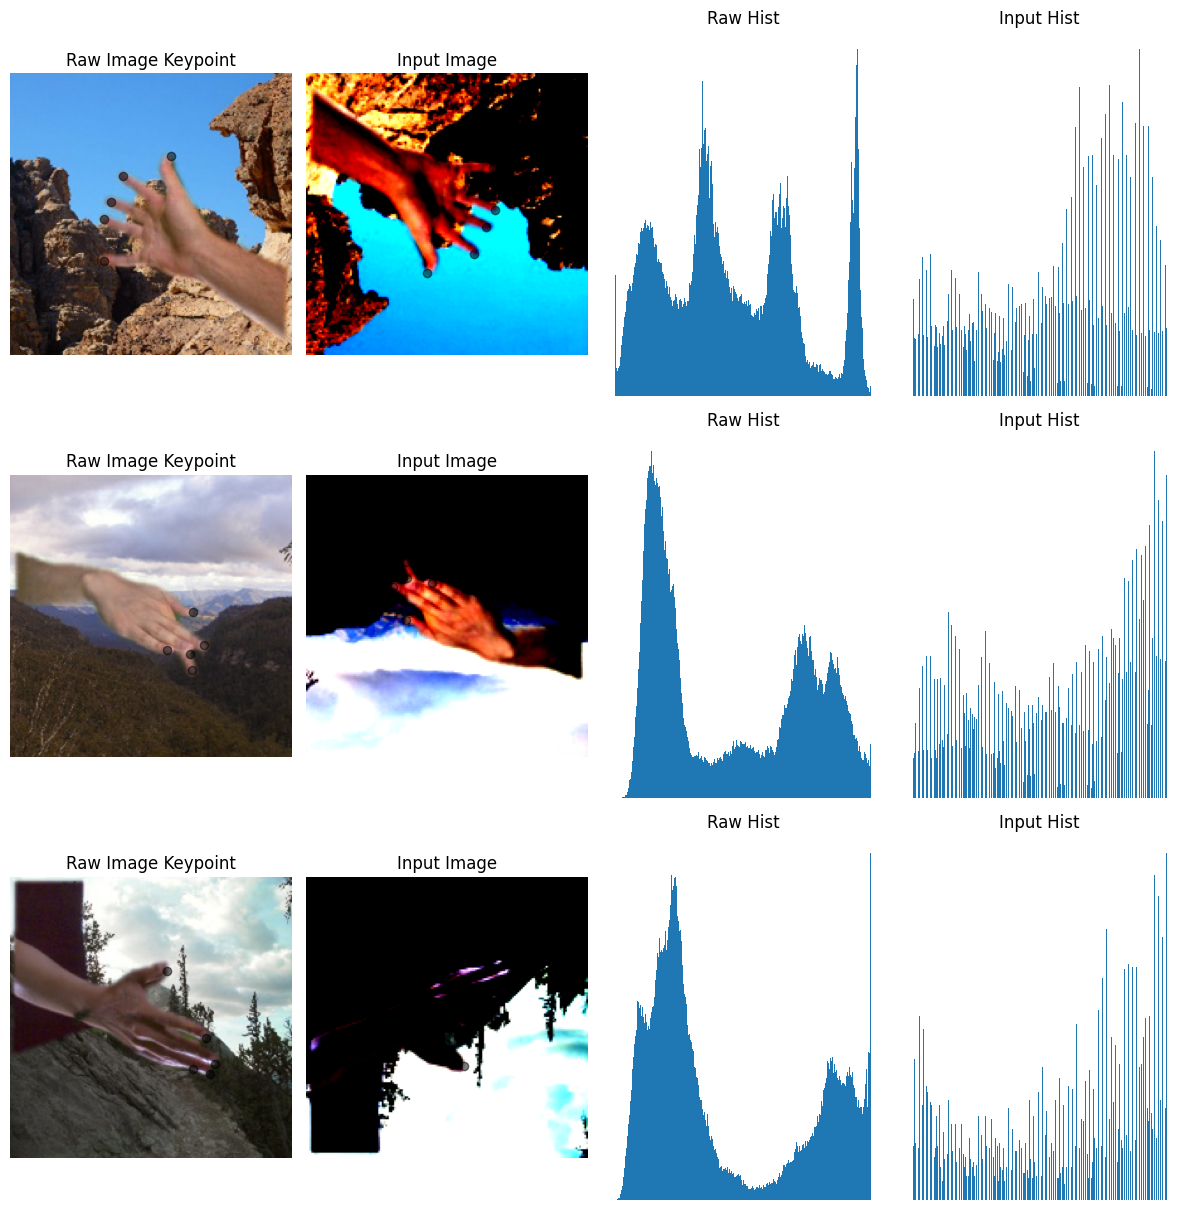

In [13]:
# visualisasi training dataset
show_data(train_dataset, n_samples=4)

In [ ]:
# print(get_norm_params(train_dataloader))

In [56]:
# membuat eval dataset
val_dataset = FreiHAND(config=config, set_type="val")
val_dataloader = DataLoader(
    val_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

[1772  160 1363 1546  991  501 1639]


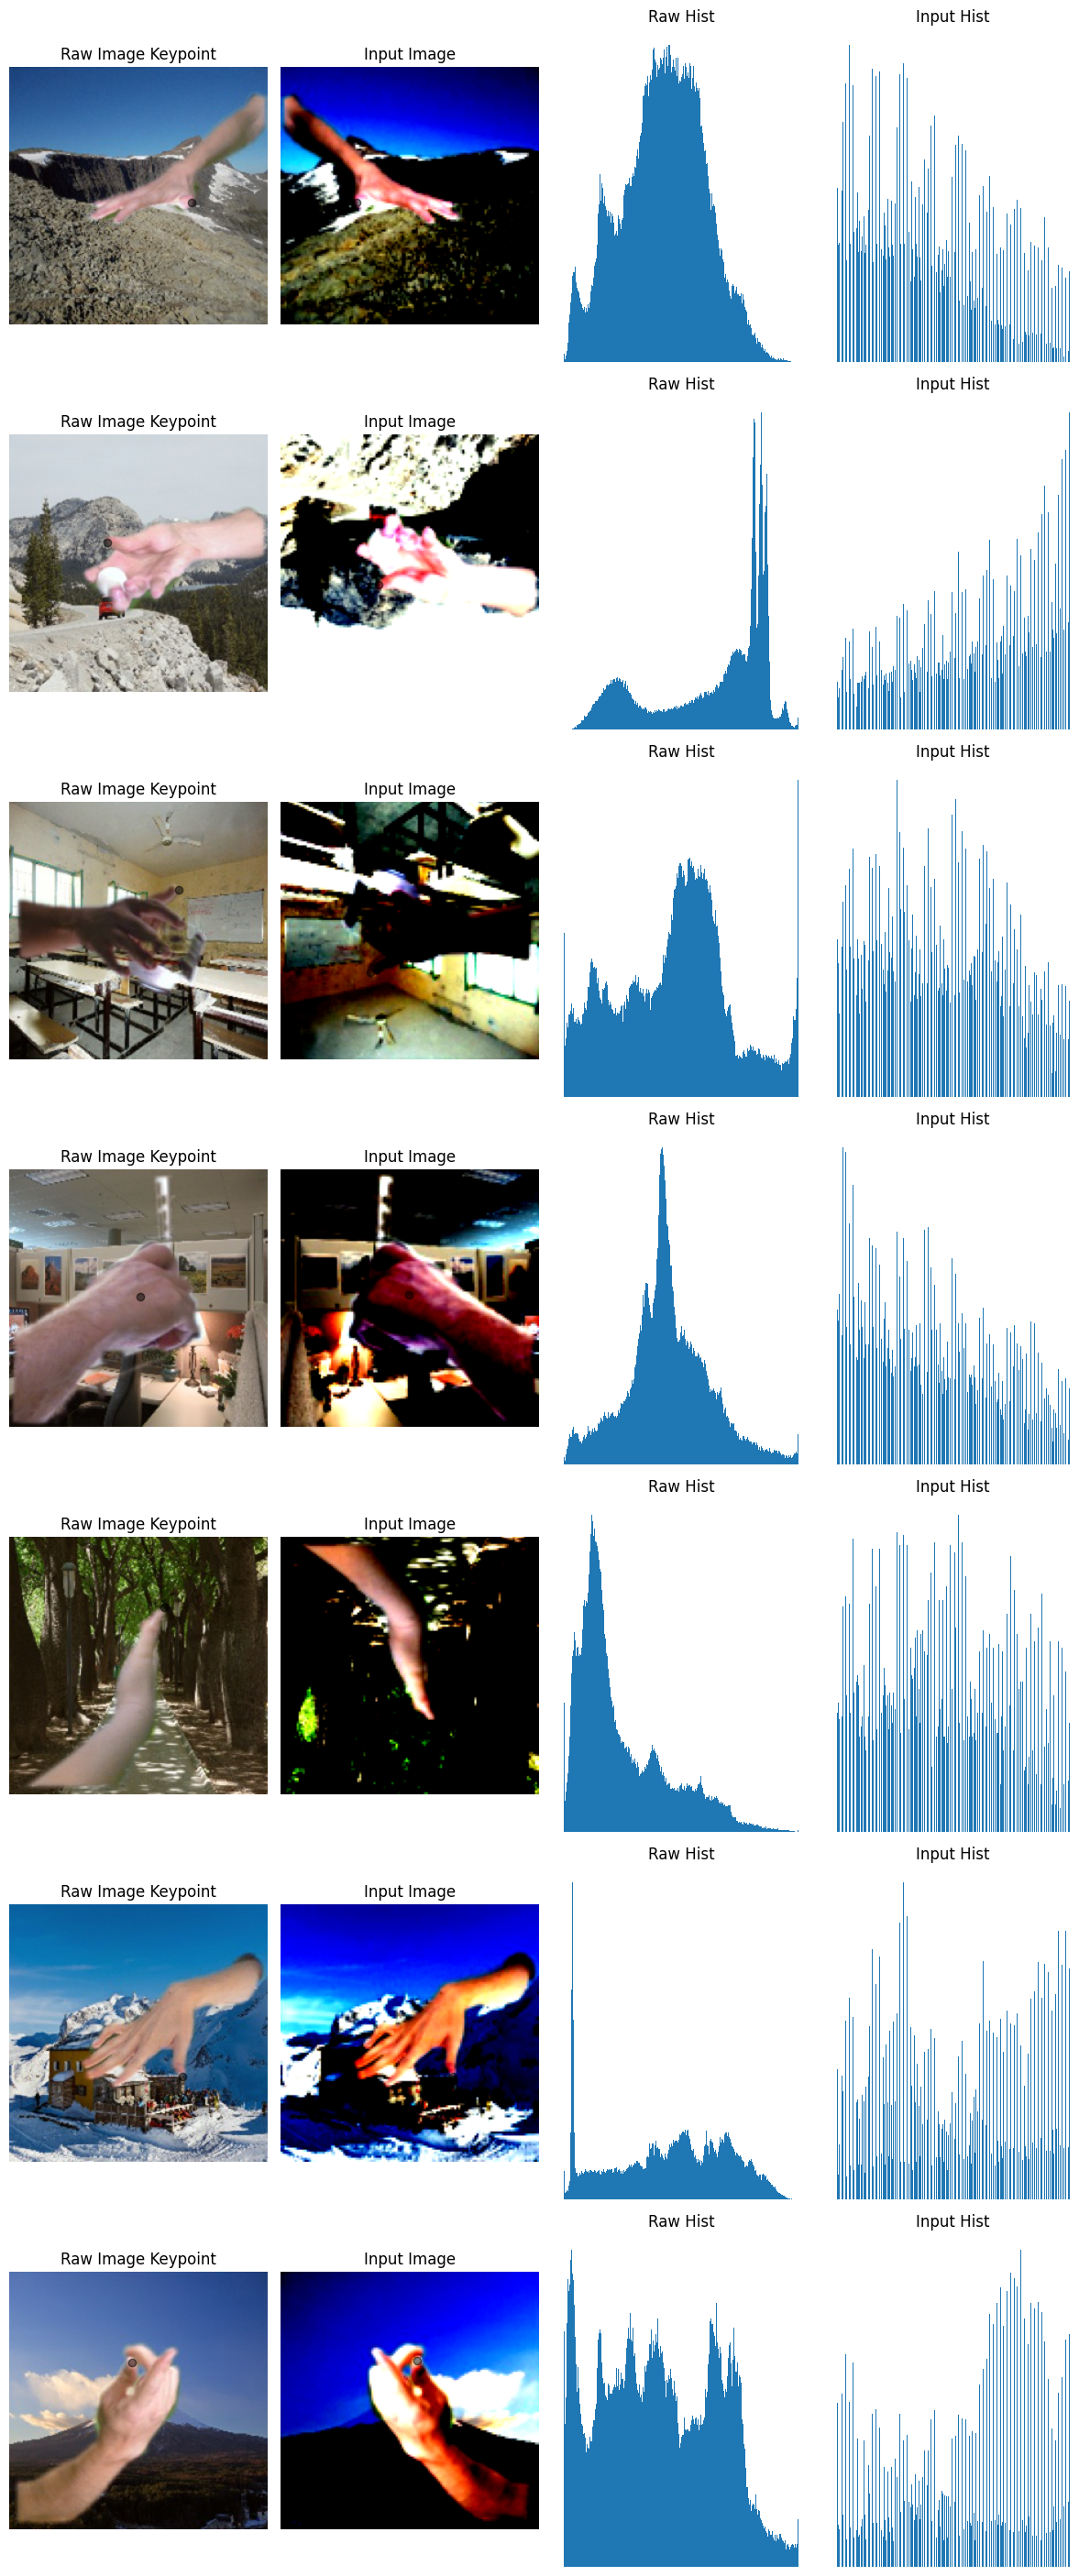

In [38]:
# visualisasi eval dataset
show_data(val_dataset, n_samples=8)

In [57]:
# membuat model U-Net
model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS)
model = model.to(config["device"])

# membuat loss function
criterion = IoULoss()

# membuat optimizer
optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"])

# membuat scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer=optimizer, T_0=10, verbose=True, eta_min=0.01, T_mult=1
)

model.eval()

Epoch 00000: adjusting learning rate of group 0 to 1.0000e-01.


DepthwiseUNet(
  (conv_in): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
  )
  (conv_down1): DepthwiseSeparableConvBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): ReLU(inplace=True)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (6): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): ReLU(inplace=True)
    )
  )
  (conv_down2): DepthwiseSeparableConvBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [58]:
# membuat trainer
trainer = Trainer(model, criterion, optimizer, config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader)

Epoch: 1/1000, Train Loss=0.992803874, Val Loss=0.9923792365
Epoch 0.99: adjusting learning rate of group 0 to 9.7829e-02.
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.09782887101430439
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 2/1000, Train Loss=0.9915359423, Val Loss=0.9901234653
Epoch 0.99: adjusting learning rate of group 0 to 9.7834e-02.
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.09783436818001756
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 3/1000, Train Loss=0.9824164183, Val Loss=0.9557452478
Epoch 0.98: adjusting learning rate of group 0 to 9.7874e-02.
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.09787370593084135
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 

KeyboardInterrupt: ignored

In [59]:
# save model
torch.save(trainer.best_model, "/content/best_model")

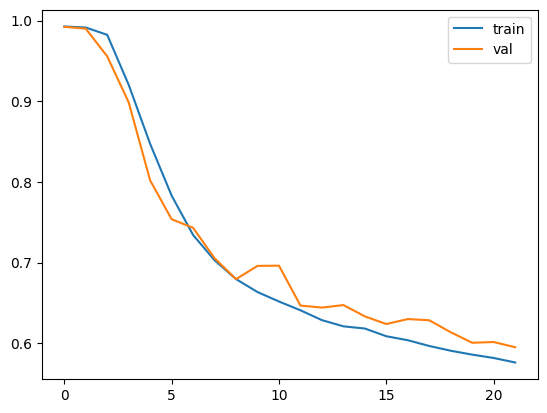

/content/drive/My Drive/Skripsi_GoogleColab/data/training/rgb/.ipynb_checkpoints


In [60]:
#visualisasi graphic training dan eval

plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()
print('/content/drive/My Drive/Skripsi_GoogleColab/data/training/rgb/.ipynb_checkpoints')

In [61]:
# Config testing
config = {
    "data_dir": "Dataset/",
    "model_path": "best_model",
    "test_batch_size": 4,
    "device": torch.device("cuda"),
}

In [62]:
# membuat dataset testing
test_dataset = FreiHAND(config=config, set_type="test")
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

In [63]:
import matplotlib
# load model
model_test = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS)
model_test.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device("cuda"))
)


<All keys matched successfully>

In [68]:
image_raw = Image.open("ftangan.png")
transform = transforms.Compose(
    [
        transforms.Resize(MODEL_IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.4639339745044708, std=0.2289445400238037)
    ]
)
image_raw = transform(image_raw)

image_raw = image_raw[None,:, :, :]
image_raw.to("cuda")

tensor([[[[-0.5362, -0.5191, -0.4677,  ...,  1.6392,  1.6563,  1.6563],
          [-0.5362, -0.5191, -0.5019,  ...,  1.6563,  1.6392,  1.6734],
          [-0.5704, -0.5019, -0.4848,  ...,  1.6734,  1.6734,  1.6734],
          ...,
          [-0.8616, -0.9130, -0.8788,  ..., -1.0329, -0.9473, -1.0158],
          [-0.9644, -0.9473, -0.9130,  ..., -1.0501, -0.9987, -0.9473],
          [-0.9815, -0.9987, -0.9644,  ..., -1.1014, -1.1014, -0.9987]],

         [[-0.4505, -0.4334, -0.4163,  ...,  1.6563,  1.6734,  1.6734],
          [-0.4848, -0.4677, -0.4334,  ...,  1.6906,  1.6734,  1.6734],
          [-0.5533, -0.4677, -0.4334,  ...,  1.6734,  1.6906,  1.6906],
          ...,
          [-0.8616, -0.9130, -0.8788,  ..., -1.0329, -0.9302, -0.9473],
          [-0.9644, -0.9644, -0.8959,  ..., -1.0501, -0.9987, -0.8959],
          [-1.0158, -1.0158, -0.9987,  ..., -1.1014, -1.1014, -0.9987]],

         [[-0.4163, -0.3992, -0.3649,  ...,  1.5878,  1.5707,  1.5364],
          [-0.3649, -0.3992, -

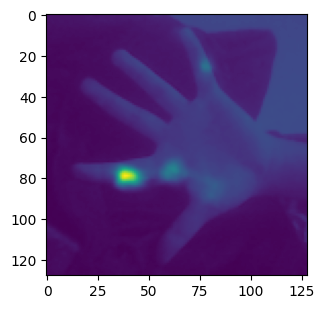

In [69]:
pred = model_test(image_raw)
pred = pred.detach().numpy()

plt.figure(figsize=[64, 64])
for i in range(len(pred[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow((image_raw[0][0] /10) + (pred[0][i] * 2))

In [ ]:
model1 = model_test.conv_in(image_raw)
output_model1 = model1.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(16):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model1[0][i])

plt.show()

In [ ]:
model2 = model_test.conv_down1(model1)
output_model2 = model2.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model2[0][i])

plt.show()

In [ ]:
model3 = model_test.conv_down2(model_test.maxpool(model2))
output_model3= model3.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model3[0][i])

plt.show()

In [ ]:
model4 = model_test.conv_down3(model_test.maxpool(model3))
output_model4 = model4.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model4[0][i])

plt.show()

In [ ]:
model_new = model_test.conv_down4(model_test.maxpool(model4))
output_model_new = model_new.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model_new[0][i])

plt.show()

In [ ]:
model5 = model_test.conv_bottleneck(model_test.maxpool(model_new))
output_model5 = model5.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model5[0][i])

plt.show()

In [ ]:
model6 = model_test.conv_up1(torch.cat([model_test.upsample(model5), model_new], dim=1))
output_model6 = model6.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model6[0][i])

plt.show()


In [ ]:
model7 = model_test.conv_up2(torch.cat([model_test.upsample(model6), model4], dim=1))
output_model7 = model7.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model7[0][i])

plt.show()



In [ ]:
model8 = model_test.conv_up3(torch.cat([model_test.upsample(model7), model3], dim=1))
output_model8 = model8.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model8[0][i])

plt.show()



In [ ]:
model9 = model_test.conv_up4(torch.cat([model_test.upsample(model8), model2], dim=1))
output_model9 = model9.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model9[0][i])

plt.show()


In [ ]:
model10 = model_test.conv_out(model9)
output_model10 = model10.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model10[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow((image_raw[0][0] /4) + (output_model10[0][i] * 2))

plt.show()

In [65]:
# melakukan testing
accuracy_all = []

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    accuracy_image = accuracy_keypoint.mean(axis=1)
    accuracy_all.extend(list(accuracy_image))

100%|██████████| 30/30 [00:01<00:00, 20.61it/s]


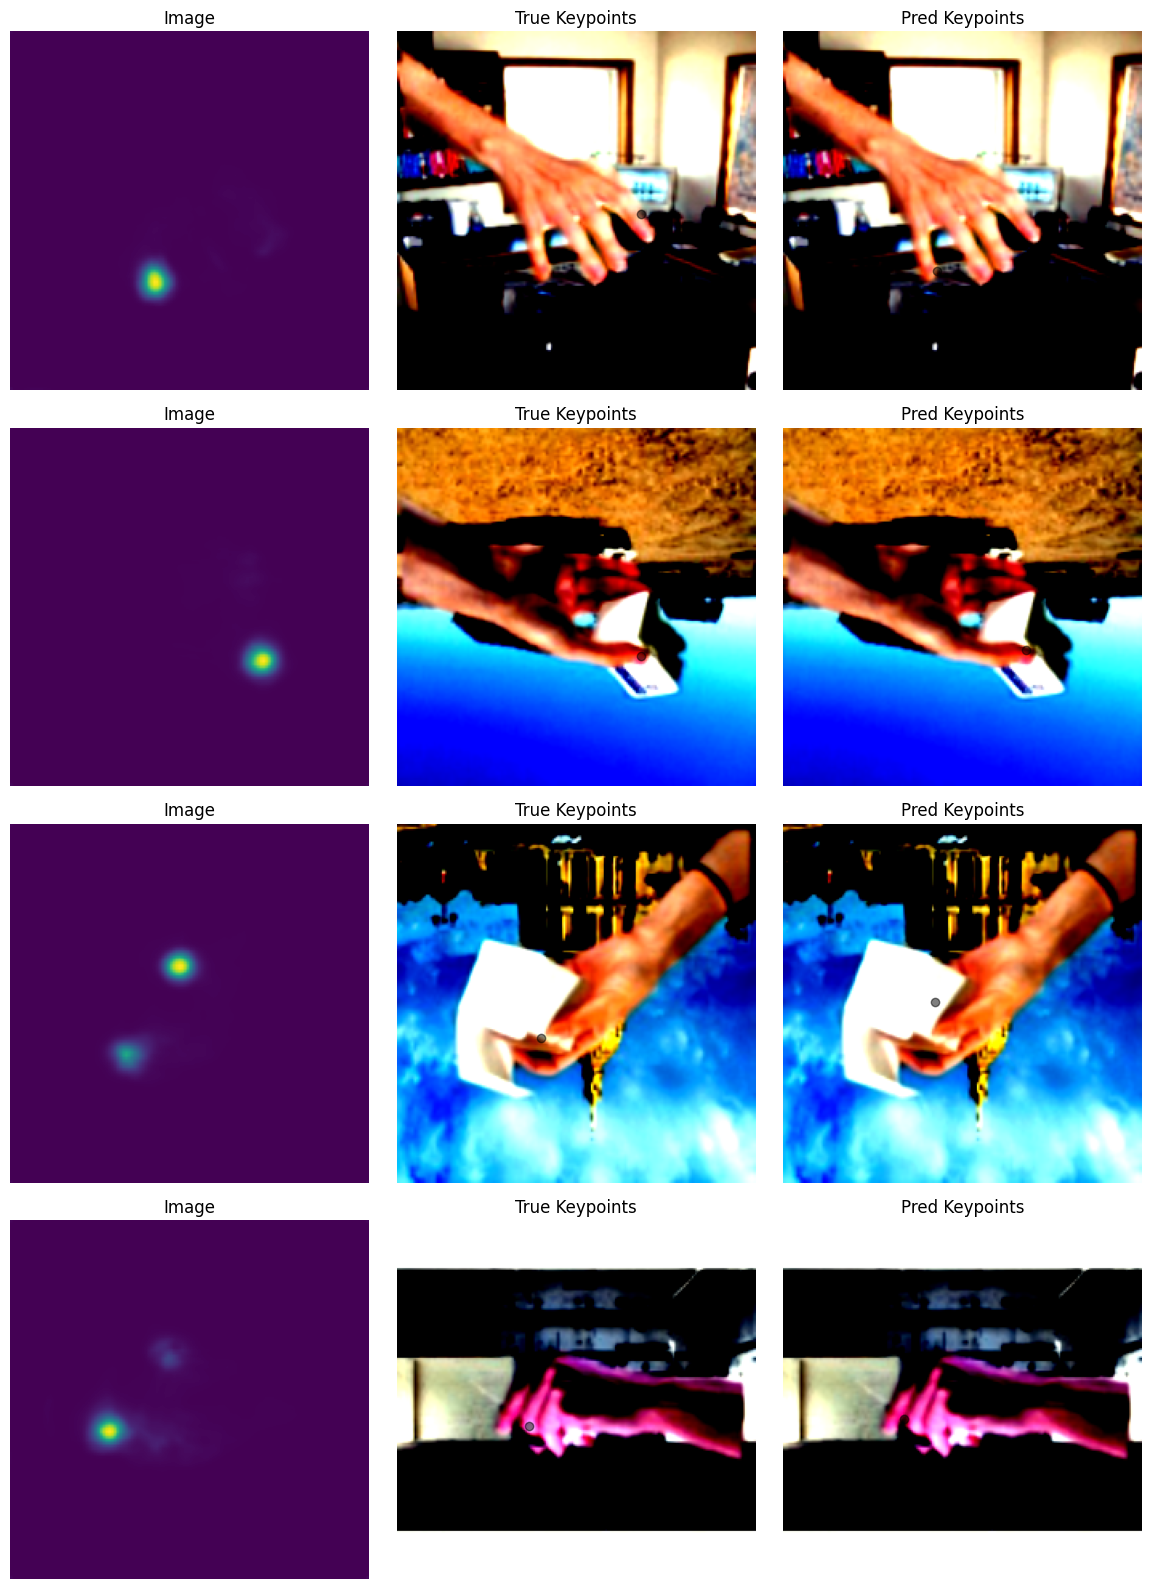

In [64]:
# visualisasi testing
for data in test_dataloader:
    show_batch_predictions(data, model)
    break